In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
# import sumo as sm
import os
from traffic_initialization import *
import sys
from bs4 import BeautifulSoup
import tqdm
import pandas as pd

# New handy interface is here!
# Check interface.py for possible parameters
from interface import Simulation
# %env SUMO_HOME=/usr/share/sumo
from datetime import datetime
# %load_ext autotime

import concurrent.futures

# Evidance of effect existence

# Optimization with annealing

In [11]:
def single_simulation(index, seed, N, d0, d1, d2, d3=2, default_gap=3):
    sim = Simulation(start_road='E0', end_road='E2', default_gap=default_gap, N=N, work_dir=f'./xml_data/threading/thread{index}', net_data='test6.net.xml')
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=d3)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run(seed=seed)

    return sim.get_mean_throughput()

In [12]:
def throughput(N, d0, d1, d2, d3=2, default_gap=3, N_ave=12):
    
    seed_list = np.random.randint(-2**30, 2**30, N_ave)
    with concurrent.futures.ThreadPoolExecutor(max_workers=N_ave) as executor:
        futures = [executor.submit(single_simulation, index, seed, N, d0, d1, d2, d3, default_gap) 
                   for index, seed in enumerate(seed_list)]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]   
    mean = np.mean(results)
    standart_deviation = np.std(results)
    
    return mean, standart_deviation

In [73]:
def loss(d, N):

    mean, _ = throughput(N=N, d0=d[0], d1=d[0], d2=d[1], N_ave=12)
    return -mean

time: 834 µs (started: 2024-04-25 19:11:23 +03:00)


In [75]:
# simple optimization

N_arr = np.zeros(6)
opt_d = np.zeros((6, 2))
opt_throughput = np.zeros(6)

for n in tqdm.tqdm(range(6)):

    N = 5050 + n*150
    
    sol = sc.optimize.dual_annealing(loss, bounds=[(10, 40), (1.5, 30)], args=[N], maxiter=50, no_local_search=True)
    ans = sol.x

    opt_d[n, :] = ans
    N_arr[n] = N
    opt_throughput[n] = -sol.fun
    
    np.savez('res_data/annealing_res_2', opt_d=opt_d, N_arr=N_arr, opt_throughput=opt_throughput)


  0%|          | 0/6 [00:09<?, ?it/s]

Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.


KeyboardInterrupt: 

time: 9.1 s (started: 2024-04-25 19:12:34 +03:00)


In [10]:
data = np.load('res_data/annealing_res.npz')
data['N_arr']

array([   0., 4150., 4300., 4450., 4600., 4750., 4900.,    0.,    0.,
          0.,    0.,    0.,    0.])

time: 3.57 ms (started: 2024-04-25 18:21:23 +03:00)


# Optimization with ML

In [5]:
from Some_models import OptimalDist

In [26]:
bad_data_filename = 'csv_data/test6.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

good_data_filename = 'csv_data/test6_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

data_filenames = [bad_data_filename, good_data_filename]
res_filenames = [bad_res_filename, good_res_filename]

obj = OptimalDist()

for i in range(len(data_filenames)):
    obj.fit_data(data_filenames[i])
    inflow = np.arange(4000, 8001, 100)
    outflow = np.zeros((len(inflow), 2))
    
    for j, n in enumerate(inflow):
        d0, d1, d2 = obj.predict(n)[0]
        outflow[j, :] = (throughput(d0, d1, d2, n))
    np.savez(res_filenames[i], N_arr=inflow, out=outflow)

C:\Users\Saviery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\Saviery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\Saviery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\Saviery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-p

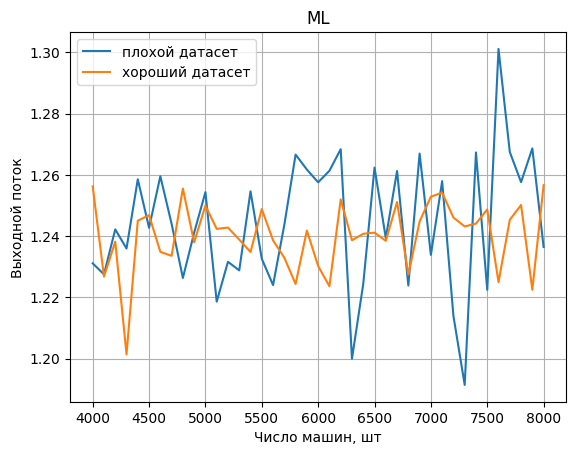

In [28]:
bad_data = np.load(bad_res_filename)
good_data = np.load(good_res_filename)

fig, ax = plt.subplots()
ax.set_title("ML")
ax.set_xlabel("Число машин, шт")
ax.set_ylabel("Выходной поток")
ax.plot(good_data['N_arr'], good_data['out'][:,0], label='плохой датасет')
ax.plot(bad_data['N_arr'], bad_data['out'][:,0], label='хороший датасет')
ax.grid()
ax.legend()
plt.show()

In [17]:
# simple throughput function with two gaps parameters

def throughput(d0, d1, d2, N):

    sim = Simulation(start_road='E0', end_road='E2', N=N, work_dir='./xml_data/test6', net_data='test6.net.xml')
    sim.set_calibrator(road='E0', gap=3)
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=2)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run()

    return sim.get_mean_throughput()

In [ ]:
while(True):
    # test6
    filename='csv_data/test6.csv'
    csv_data = pd.read_csv(filename)
    
    N = np.random.randint(3000, 8000)
    for i in range(500):
        rand = np.random.rand(3)
        d0 = 10 + 40*rand[0]
        d1 = 10 + 30*rand[1]
        d2 = 3 + 30*rand[2]
        
        csv_data.loc[len(csv_data)] = (d0, d1, d2, N, throughput(d0, d1, d2, N))
        csv_data.to_csv(filename, index=False) 

In [11]:
model = OptimalDist(grid_params=[(4000, 8000, 41), (10, 40, 2), (2, 20, 2)])
model.fit_func(еthroughput)

  0%|          | 0/98 [00:33<?, ?it/s]


ValueError: cannot set a row with mismatched columns

time: 33.3 s (started: 2024-04-24 20:08:33 +03:00)
